# Wine Quality - Minuntrade challenge

Importing the libraries

In [400]:
#Importando as bibliotecas

# Data Analysis Tools
import pandas as pd
import numpy as np
from sklearn.preprocessing import Normalizer

# Visualization Tools
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.display import display

# Machine Learning Tools
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.grid_search import GridSearchCV
from sklearn.decomposition import PCA


#Scoreing tools
from sklearn.metrics import silhouette_score
from sklearn.metrics import explained_variance_score


# Data Engineering 

On the following cells, it is set some data engineering about the features. It will be done a very simple data exploration based on the given columns.

Some work of the rows/columns may be done if some not standard value is found.

Finally, a feature importance using a desicion tree will be done to understand what really matters to the wine quality.

In [401]:
data_raw = pd.read_csv('winequality.csv', sep=';')

In [402]:
data_raw.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,White,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,White,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,White,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [403]:
data_raw.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,1.710882,3.218501,0.531268,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,7.636088,0.160787,0.148806,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,103.898000,4.010000,2.000000,9.000000


In [404]:
data_raw.dtypes

type                     object
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                  object
quality                   int64
dtype: object

In [405]:
data_raw.select_dtypes(include=['object']).count()

type       6497
alcohol    6497
dtype: int64

In [406]:
data_raw = data_raw[pd.to_numeric(data_raw['alcohol'], errors='coerce').notnull()]

In [407]:
data_raw['alcohol'] = pd.to_numeric(data_raw['alcohol'], errors='coerce').fillna(-1)
data_raw.dtypes

type                     object
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

In [408]:
data_raw['alcohol'].fillna(-1, inplace=True)

In [409]:
data_raw = pd.concat([data_raw, pd.get_dummies(data_raw['type'])], axis=1)
data_raw = data_raw.drop(['type'], axis = 1)

In [410]:
data_raw.isnull().values.any()

False

In [411]:
data_raw = data_raw.dropna(how='any',axis=0)

In [412]:
data_raw.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Red,White
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,0,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,0,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,0,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0,1


In [413]:
def plot_corr_heatmap(corr_matrix):
    
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr_matrix, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(20, 10))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap="Blues", vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": 0.9},annot= True)
    plt.savefig('Correlation map.png', format='png', dpi=100)

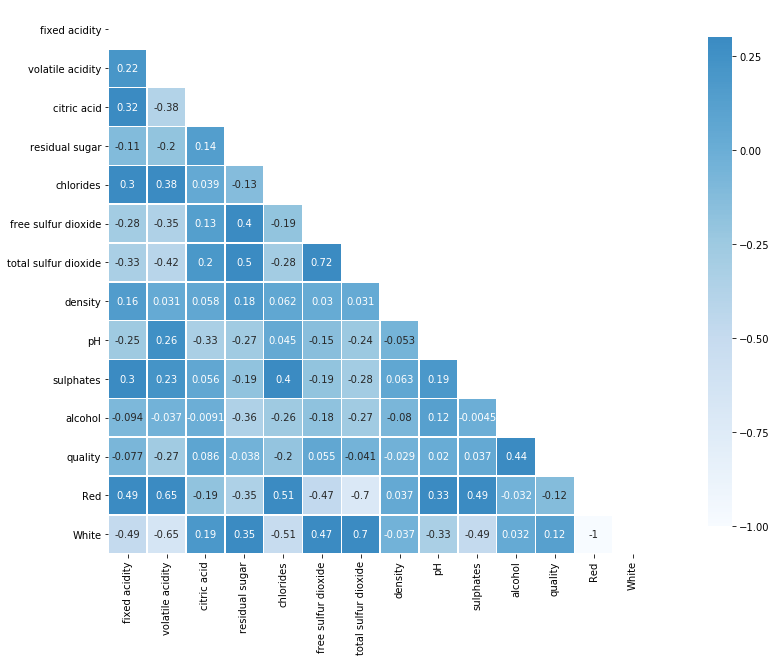

In [414]:
corr = data_raw.corr()
plot_corr_heatmap(corr)

In [415]:
X = data_raw.values
y = data_raw['quality'].values



forest = ExtraTreesClassifier(n_estimators=20,
                              random_state=0,
                              max_depth = 1000)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]


# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 11 (0.727382)
2. feature 10 (0.053406)
3. feature 1 (0.030312)
4. feature 6 (0.023203)
5. feature 5 (0.021529)
6. feature 9 (0.021466)
7. feature 7 (0.020592)
8. feature 3 (0.020190)
9. feature 4 (0.019982)
10. feature 2 (0.019255)
11. feature 8 (0.018589)
12. feature 0 (0.016927)
13. feature 12 (0.003809)
14. feature 13 (0.003359)


In [416]:
list(data_raw)

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'quality',
 'Red',
 'White']

## Data Engineering results

After the data engineering, can be implied that:

1. alcohol has 73% of feature importance;
2. sulphates has 5% of feature importance;
3. fixed acidity has 3% of feature importance.

Also, there were some values with wrong format in the alcohol column. It was treated and set as (-1).

# Data Visualization

In [417]:
Counter(data_raw['quality'])

Counter({6: 2815, 5: 2129, 7: 1069, 8: 193, 4: 216, 3: 30, 9: 5})

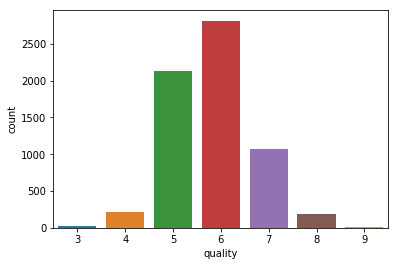

In [418]:
sns.countplot(x='quality', data=data_raw)

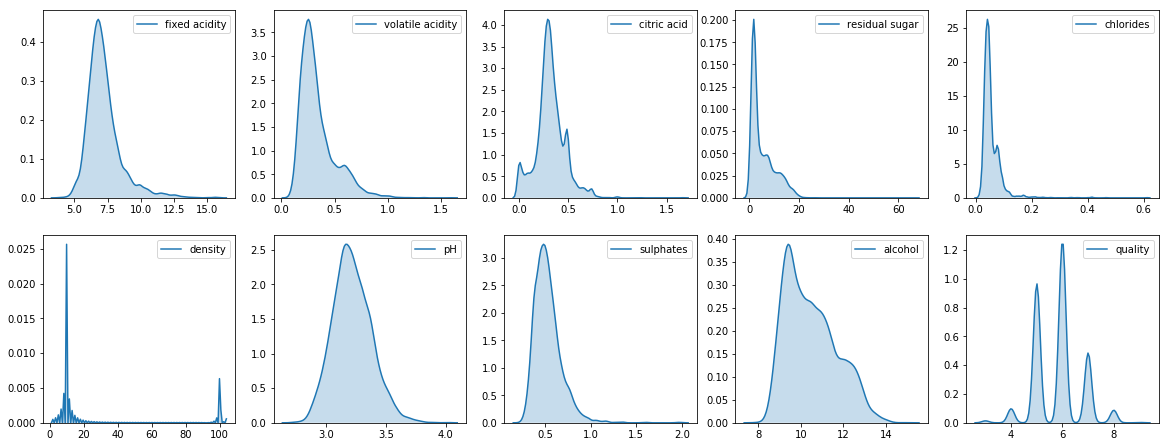

In [419]:
fig = plt.figure(figsize = (20,20)) # width x height
ax1 = fig.add_subplot(5, 5, 1) # row, column, position
ax2 = fig.add_subplot(5, 5, 2)
ax3 = fig.add_subplot(5, 5, 3)
ax4 = fig.add_subplot(5, 5, 4)
ax5 = fig.add_subplot(5, 5, 5)
ax6 = fig.add_subplot(5, 5, 6)
ax7 = fig.add_subplot(5, 5, 7)
ax8 = fig.add_subplot(5, 5, 8)
ax9 = fig.add_subplot(5, 5, 9)
ax10 = fig.add_subplot(5, 5, 10)

sns.kdeplot(data_raw['fixed acidity'], shade=True, ax=ax1)
sns.kdeplot(data_raw['volatile acidity'], shade=True, ax=ax2)
sns.kdeplot(data_raw['citric acid'], shade=True, ax=ax3)
sns.kdeplot(data_raw['residual sugar'], shade=True, ax=ax4)
sns.kdeplot(data_raw['chlorides'], shade=True, ax=ax5)
sns.kdeplot(data_raw['density'], shade=True, ax=ax6)
sns.kdeplot(data_raw['pH'], shade=True, ax=ax7)
sns.kdeplot(data_raw['sulphates'], shade=True, ax=ax8)
sns.kdeplot(data_raw['alcohol'], shade=True, ax=ax9)
sns.kdeplot(data_raw['quality'], shade=True, ax=ax10)

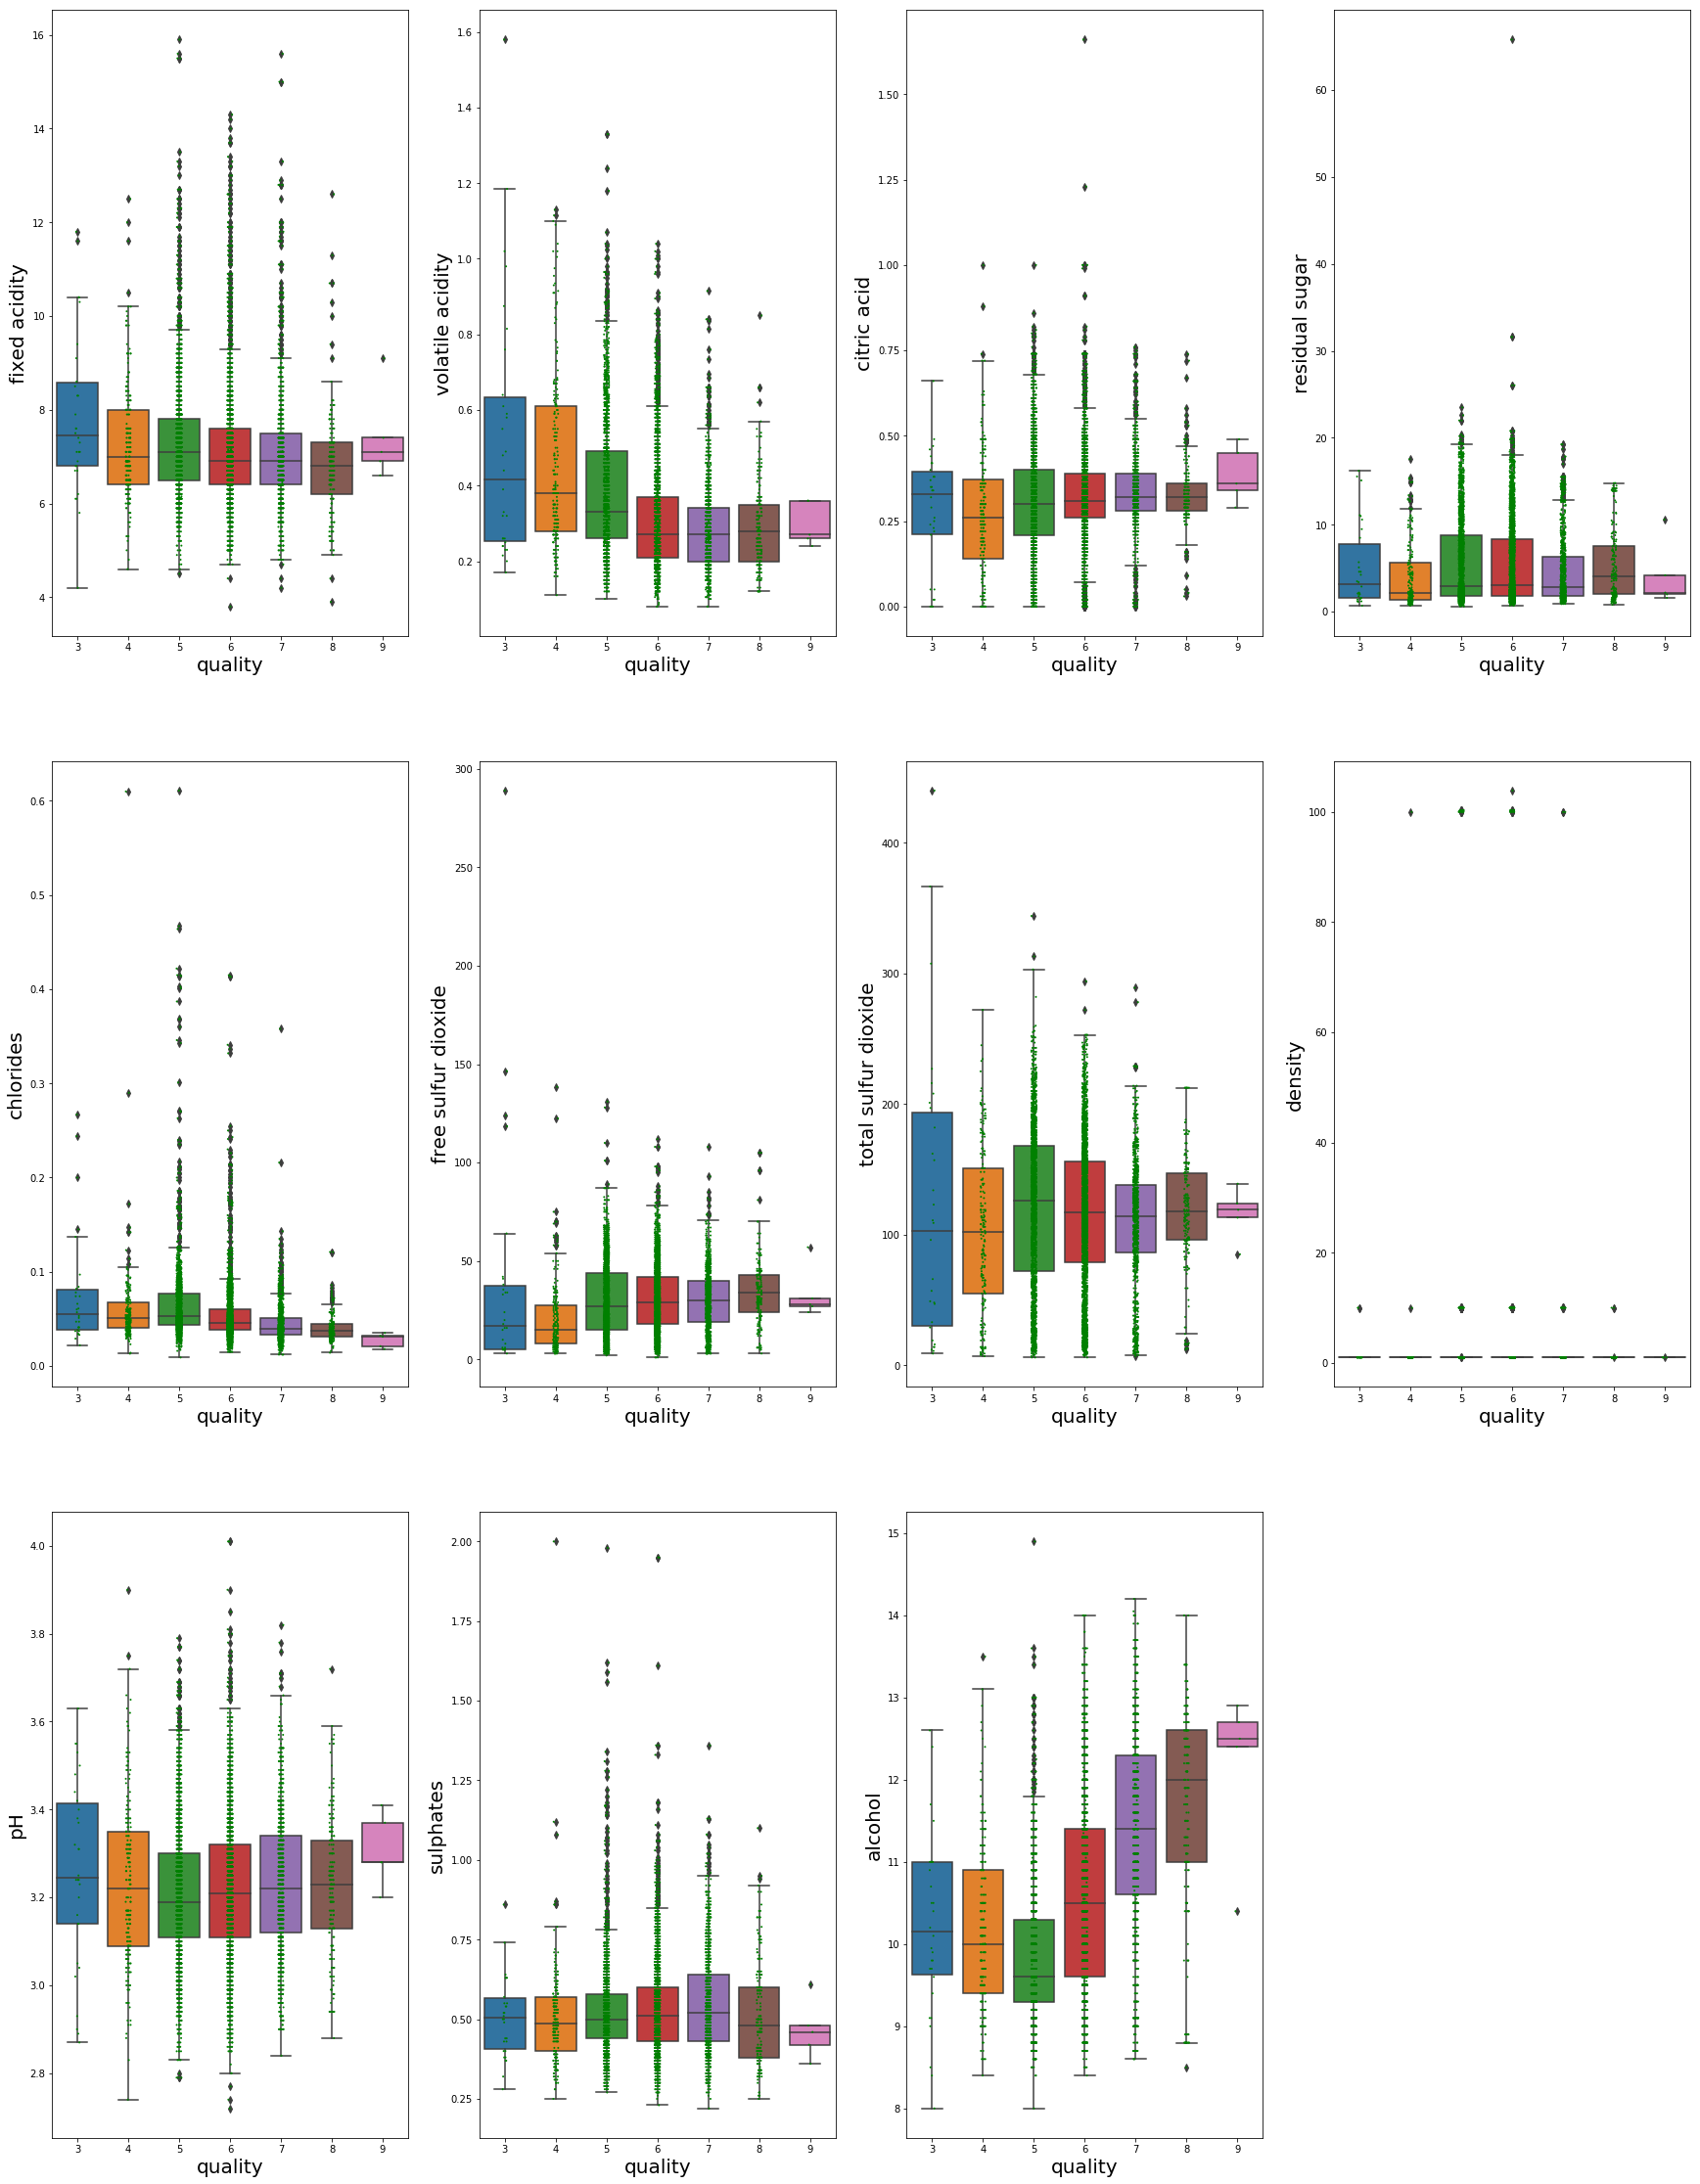

In [420]:
fig = plt.figure(figsize = (30,40)) # width x height
ax1 = fig.add_subplot(3, 4, 1) # row, column, position
ax2 = fig.add_subplot(3, 4, 2)
ax3 = fig.add_subplot(3, 4, 3)
ax4 = fig.add_subplot(3, 4, 4)
ax5 = fig.add_subplot(3, 4, 5)
ax6 = fig.add_subplot(3, 4, 6)
ax7 = fig.add_subplot(3, 4, 7)
ax8 = fig.add_subplot(3, 4, 8)
ax9 = fig.add_subplot(3, 4, 9)
ax10 = fig.add_subplot(3, 4, 10)
ax11 = fig.add_subplot(3, 4, 11)

sns.boxplot(x='quality', y=data_raw['fixed acidity'], data=data_raw, ax=ax1)
sns.stripplot(x='quality', y=data_raw['fixed acidity'], data=data_raw, color="green", jitter=0.05, size=2, ax=ax1)
ax1.xaxis.label.set_size(20)
ax1.yaxis.label.set_size(20)

sns.boxplot(x='quality', y=data_raw['volatile acidity'], data=data_raw, ax=ax2)
sns.stripplot(x='quality', y=data_raw['volatile acidity'], data=data_raw, color="green", jitter=0.05, size=2, ax=ax2)
ax2.xaxis.label.set_size(20)
ax2.yaxis.label.set_size(20)

sns.boxplot(x='quality', y=data_raw['citric acid'], data=data_raw, ax=ax3)
sns.stripplot(x='quality', y=data_raw['citric acid'], data=data_raw, color="green", jitter=0.05, size=2, ax=ax3)
ax3.xaxis.label.set_size(20)
ax3.yaxis.label.set_size(20)

sns.boxplot(x='quality', y=data_raw['residual sugar'], data=data_raw, ax=ax4)
sns.stripplot(x='quality', y=data_raw['residual sugar'], data=data_raw, color="green", jitter=0.05, size=2, ax=ax4)
ax4.xaxis.label.set_size(20)
ax4.yaxis.label.set_size(20)

sns.boxplot(x='quality', y=data_raw['chlorides'], data=data_raw, ax=ax5)
sns.stripplot(x='quality', y=data_raw['chlorides'], data=data_raw, color="green", jitter=0.05, size=2, ax=ax5)
ax5.xaxis.label.set_size(20)
ax5.yaxis.label.set_size(20)

sns.boxplot(x='quality', y=data_raw['free sulfur dioxide'], data=data_raw, ax=ax6)
sns.stripplot(x='quality', y=data_raw['free sulfur dioxide'], data=data_raw, color="green", jitter=0.05, size=2, ax=ax6)
ax6.xaxis.label.set_size(20)
ax6.yaxis.label.set_size(20)

sns.boxplot(x='quality', y=data_raw['total sulfur dioxide'], data=data_raw, ax=ax7)
sns.stripplot(x='quality', y=data_raw['total sulfur dioxide'], data=data_raw, color="green", jitter=0.05, size=2, ax=ax7)
ax7.xaxis.label.set_size(20)
ax7.yaxis.label.set_size(20)

sns.boxplot(x='quality', y=data_raw['density'], data=data_raw, ax=ax8)
sns.stripplot(x='quality', y=data_raw['density'], data=data_raw, color="green", jitter=0.05, size=2, ax=ax8)
ax8.xaxis.label.set_size(20)
ax8.yaxis.label.set_size(20)

sns.boxplot(x='quality', y=data_raw['pH'], data=data_raw, ax=ax9)
sns.stripplot(x='quality', y=data_raw['pH'], data=data_raw, color="green", jitter=0.05, size=2, ax=ax9)
ax9.xaxis.label.set_size(20)
ax9.yaxis.label.set_size(20)

sns.boxplot(x='quality', y=data_raw['sulphates'], data=data_raw, ax=ax10)
sns.stripplot(x='quality', y=data_raw['sulphates'], data=data_raw, color="green", jitter=0.05, size=2, ax=ax10)
ax10.xaxis.label.set_size(20)
ax10.yaxis.label.set_size(20)

sns.boxplot(x='quality', y=data_raw['alcohol'], data=data_raw, ax=ax11)
sns.stripplot(x='quality', y=data_raw['alcohol'], data=data_raw, color="green", jitter=0.05, size=2, ax=ax11)
ax11.xaxis.label.set_size(20)
ax11.yaxis.label.set_size(20)



From the boxplot and the kdeplot above we can see that some outliers are presented in the data. I point out the density feature that has a huge difference and can be better indentified, because a density of 100 against 1 is, at least, suspect. Some anaylis will be done below:


In [421]:
print (data_raw['density'][data_raw['density'] > 1.1].count())

136


As the value should not be greater than 1,000, the values will be divided by 10 or by 100:

In [422]:
data_raw.loc[data_raw['density'].values > 5, 'density']/= 10
data_raw.loc[data_raw['density'].values > 5, 'density']/= 10

data_raw['density'].describe()

count    6457.000000
mean        0.994707
std         0.002999
min         0.987110
25%         0.992350
50%         0.994900
75%         0.997000
max         1.038980
Name: density, dtype: float64

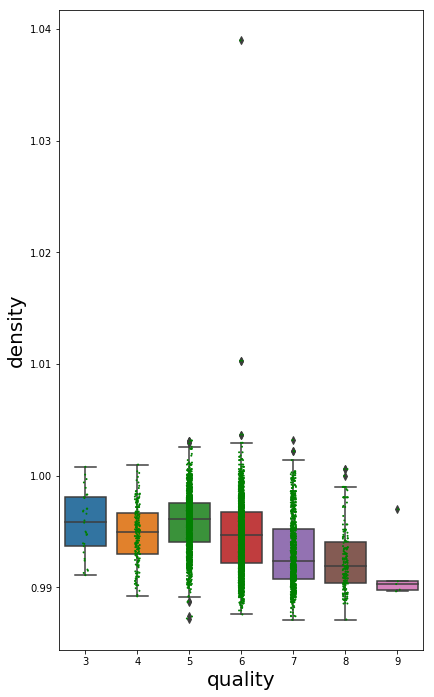

In [423]:
fig = plt.figure(figsize = (30,40))
ax8 = fig.add_subplot(3, 4, 8)
sns.boxplot(x='quality', y=data_raw['density'], data=data_raw, ax=ax8)
sns.stripplot(x='quality', y=data_raw['density'], data=data_raw, color="green", jitter=0.05, size=2, ax=ax8)
ax8.xaxis.label.set_size(20)
ax8.yaxis.label.set_size(20)

As we have from 0 to 9 possibilities of classification, we can create a new column to make groups of bad, good and awesome wines.

Let's set:

* 1 - bad wine (0-3 quality)
* 2 - good wine (3-7 quality)
* 3 - awesome wine (7-10 quality)

In [424]:
group_quality = []

for k in data_raw['quality']:
    if k >= 0 and k <= 3:
        group_quality.append('1')
    elif k > 3 and k <= 7:
        group_quality.append('2')
    elif k > 7:
        group_quality.append('3')
data_raw['group_quality'] = group_quality

In [425]:
data_raw.groupby('group_quality').count()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Red,White
group_quality,,,,,,,,,,,,,,
1,30,30,30,30,30,30,30,30,30,30,30,30,30,30
2,6229,6229,6229,6229,6229,6229,6229,6229,6229,6229,6229,6229,6229,6229
3,198,198,198,198,198,198,198,198,198,198,198,198,198,198


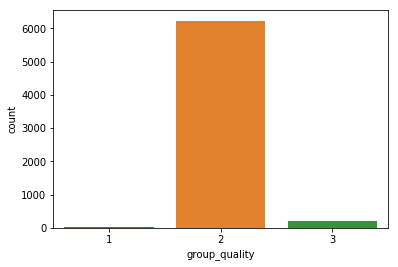

In [426]:
sns.countplot(x='group_quality', data=data_raw)

# Clustering

Here a PCA analysis is done to check the principal components that can explain the target variable.

In [450]:
data_raw = data_raw.dropna(how='any',axis=0)
data_raw_ = data_raw
data_raw_.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Red,White,Clusters PCA
count,6457.000000,6457.000000,6457.000000,6457.000000,6457.000000,6457.000000,6457.000000,6457.000000,6457.000000,6457.000000,6457.000000,6457.000000,6457.000000,6457.000000,6457.000000
mean,7.219475,0.339684,0.318795,5.445973,0.056081,30.495586,115.690801,0.994707,3.218592,0.531169,10.489083,5.817098,0.246709,0.753291,0.849621
std,1.294910,0.164690,0.145506,4.764308,0.035110,17.757007,56.595196,0.002999,0.160845,0.148870,1.192961,0.874125,0.431129,0.431129,0.852958
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000,0.000000,0.000000,0.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992350,3.110000,0.430000,9.500000,5.000000,0.000000,1.000000,0.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994900,3.210000,0.510000,10.300000,6.000000,0.000000,1.000000,1.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.997000,3.320000,0.600000,11.300000,6.000000,0.000000,1.000000,2.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000,1.000000,1.000000,2.000000


In [451]:
from sklearn.decomposition import PCA

PCA = PCA(n_components=12)
PrincipleComponents = PCA.fit_transform(data_raw_)
variance = PCA.explained_variance_ratio_
variance_ratio = np.cumsum(np.round(variance, decimals=3)*100)
variance_ratio

array([ 95.3,  99.4,  99.9, 100. , 100. , 100. , 100. , 100. , 100. ,
       100. , 100. , 100. ])

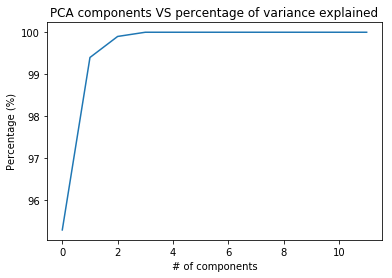

In [452]:
plt.title("PCA components VS percentage of variance explained")
plt.ylabel("Percentage (%)")
plt.xlabel("# of components")
plt.plot(variance_ratio)

In [453]:
TakenPCA = PrincipleComponents[:,:2]
TakenPCA

array([[ 56.78470935,   1.84023517],
       [ 11.90820384, -19.88971123],
       [-18.23197139,   3.85638373],
       ...,
       [-74.06122151,  15.9996323 ],
       [-69.48644466,  17.97778958],
       [-74.59384902,   4.86419663]])

In [455]:
kmc = KMeans(n_clusters = 2, max_iter=100)
kmc.fit_transform(TakenPCA)

data_raw_["Clusters PCA"] = kmc.labels_
data_raw_.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Red,White,group_quality,Clusters PCA
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,0,1,2,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,0,1,2,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,0,1,2,0
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0,1,2,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0,1,2,1


After the analysis, it was created a column called 'Clusters PCA' that group the dataset into 2 clusters from the component analysis. It can be said that we have 2 principal components that explain 99% of the data variance.

## Normalizing data

Normalizing the dataset. This action may prevent local minima in the learning algorithm

In [456]:
def normalize(dataset):
    dataNorm=((dataset-dataset.min())/(dataset.max()-dataset.min()))

    return dataNorm

In [457]:
data = normalize(data_raw.drop(["quality","group_quality" ], axis = 1)).copy()
data["quality"] = data_raw["quality"]
data["group_quality"] = data_raw_["group_quality"]
data["Clusters PCA"] = data_raw_["Clusters PCA"]

count    6457.00000
mean        0.56311
std         0.49604
min         0.00000
25%         0.00000
50%         1.00000
75%         1.00000
max         1.00000
Name: Clusters PCA, dtype: float64

# Salving dataset for ML algorithms

In [458]:
#Normalized Dataset
data.to_csv('Normdata.csv',sep=',',index = True)

In [347]:
#Dataset
data_raw.to_csv('data.csv',sep=',',index = True)

In [399]:
#Dataset_clustered
data_raw_.to_csv('data_test.csv',sep=',',index = True)